In [802]:
import numpy as np
import datetime as dt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [803]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()
capital = 10_000
years = (end - start).days/365.25
ticker = "^GSPC"

In [804]:
price = yf.download(ticker, start=start, end=end, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [805]:
price.columns = price.columns.get_level_values(0).rename(None)
price.drop(columns=["Low", "High", "Volume"], inplace=True)

In [806]:
price.head()

,Close,Open
Date,,
2010-01-04,1132.989990,1116.560059
2010-01-05,1136.520020,1132.660034
2010-01-06,1137.140015,1135.709961
2010-01-07,1141.689941,1136.270020
2010-01-08,1144.979980,1140.520020


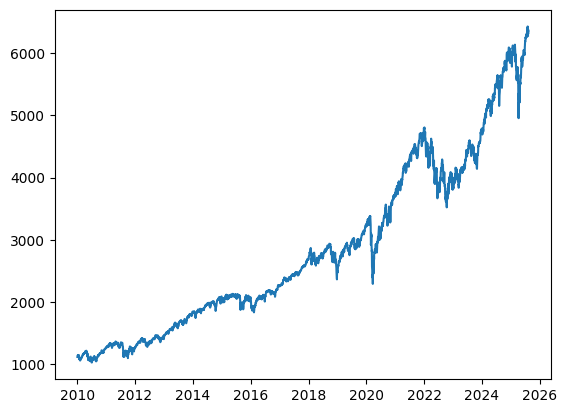

In [807]:
plt.plot(price["Open"])
plt.show()

In [808]:
price["Return"] = price["Close"]/price["Close"].shift(1)
price.loc[price.index[0], "Return"] = price["Close"][price.index[0]]/price["Open"][price.index[0]]
price.head()

,Close,Open,Return
Date,,,
2010-01-04,1132.989990,1116.560059,1.014715
2010-01-05,1136.520020,1132.660034,1.003116
2010-01-06,1137.140015,1135.709961,1.000546
2010-01-07,1141.689941,1136.270020,1.004001
2010-01-08,1144.979980,1140.520020,1.002882


In [809]:
price["HODL"] = capital * np.cumprod(price["Return"])

Annual growth rate :

\begin{equation*}
\text{Capital}_{end} = \text{Capital}_{start}(1+r)^n \quad \Longrightarrow \quad r=\left(\frac{\text{Capital}_{end}}{\text{Capital}_{start}}\right)^\frac1n - 1
\end{equation*}

In [810]:
hodl = {'roi': np.round((price["HODL"][price.index[-1]]/price["HODL"][price.index[0]] - 1) * 100, 2), 
        'cagr': np.round(((price["HODL"][price.index[-1]]/price["HODL"][price.index[0]])**(1/years) - 1) * 100, 2)}

In [811]:
price["HODL_Peak"] = np.maximum.accumulate(price["HODL"])
price["HODL_Drawdown"] = price["HODL"] - price["HODL_Peak"]

In [812]:
hodl["max_dd"] = np.round(np.min(price["HODL_Drawdown"]/price["HODL_Peak"]) * 100, 2)

In [813]:
print(hodl)

{'roi': np.float64(463.95), 'cagr': np.float64(11.72), 'max_dd': np.float64(-33.92)}


The trading stradegy relies on a "slow" moving average.

In [814]:
slow_period = 200
window = np.ones(slow_period)/slow_period
SMA = pd.Series(np.convolve(price["Open"], window, mode='valid'), index=price.index[slow_period - 1:])

In [815]:
price["SMA"] = SMA

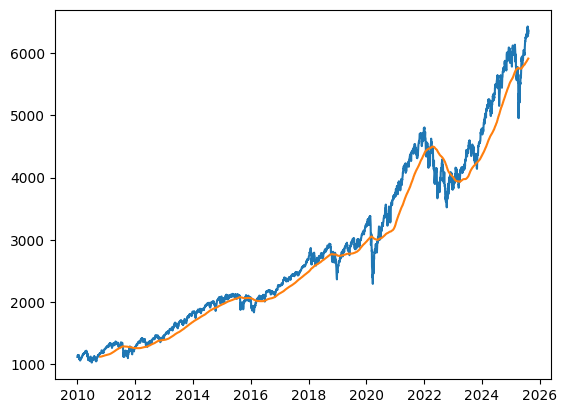

In [816]:
plt.plot(price["Open"])
plt.plot(price["SMA"])
plt.show()

In [817]:
price["in_market"] = (price["Open"] > price["SMA"])

In [818]:
price["SMA_Return"] = np.where(price["in_market"] == True, price["Return"], 1)
price["SMA_Capital"] = np.cumprod(price["SMA_Return"]) * capital

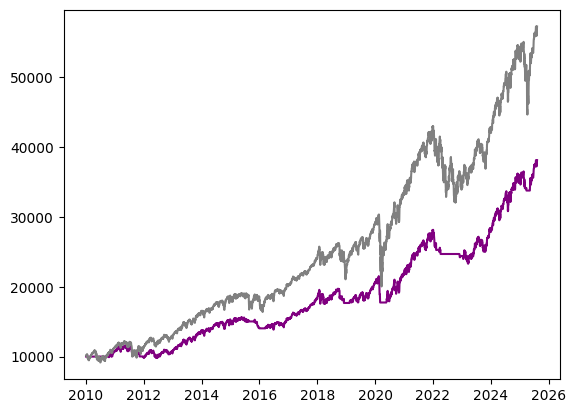

In [819]:
plt.plot(price["SMA_Capital"], color="purple")
plt.plot(price["HODL"], color='grey')
plt.show()

In [820]:
price["SMA_Peak"] = np.maximum.accumulate(price["SMA_Capital"])
price["SMA_Drawdown"] = price["SMA_Capital"] - price["SMA_Peak"]

In [821]:
startegy = {'roi': np.round((price["SMA_Capital"][price.index[-1]]/price["SMA_Capital"][price.index[0]] - 1) * 100, 2), 
        'cagr': np.round(((price["SMA_Capital"][price.index[-1]]/price["SMA_Capital"][price.index[0]])**(1/years) - 1) * 100, 2),
        'max_dd': np.round(np.min(price["SMA_Drawdown"]/price["SMA_Peak"]) * 100, 2)}

In [822]:
comp_table = pd.DataFrame([hodl, startegy], index=["HODL", "SMA Strategy"])
print(comp_table)

                 roi   cagr  max_dd
HODL          463.95  11.72  -33.92
SMA Strategy  281.06   8.95  -17.40


The second strategy involves 2 moving averages, one fast and one slow.

In [823]:
fast_period = 50
window = np.ones(fast_period)/fast_period
price["FMA"] = pd.Series(np.convolve(price["Open"], window, mode='valid'), index=price.index[fast_period - 1:])

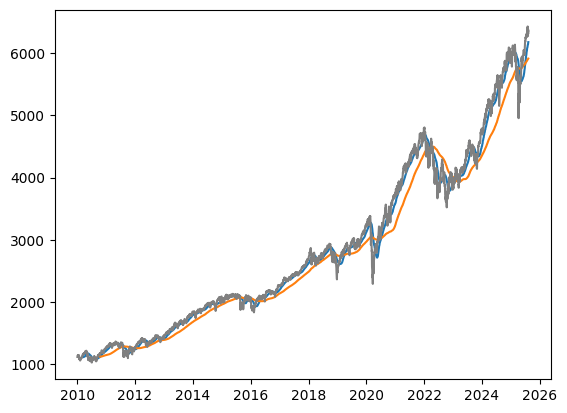

In [824]:
plt.plot(price["FMA"])
plt.plot(price["SMA"])
plt.plot(price["Open"], color="grey")
plt.show()

In [825]:
price["in_market_2"] = price["FMA"] > price["SMA"]
price["Strat_2_Return"] = np.where(price["in_market_2"] == True, price["Return"], 1)
price["Strat_2_Capital"] = np.cumprod(price["Strat_2_Return"]) * capital

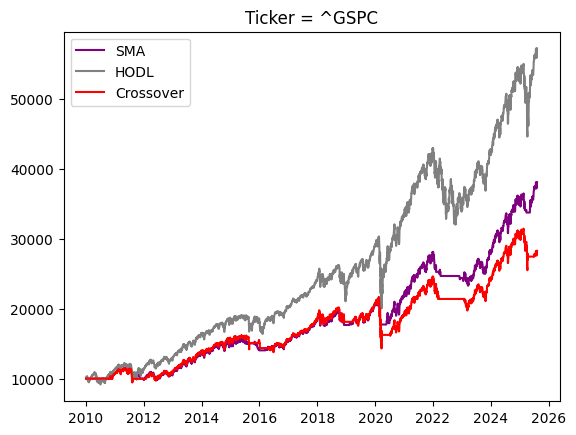

In [826]:
plt.plot(price["SMA_Capital"], color="purple", label="SMA")
plt.plot(price["HODL"], color="grey", label="HODL")
plt.plot(price["Strat_2_Capital"], color="red", label="Crossover")
plt.legend()
plt.title(f"Ticker = {ticker}")
plt.show()

In [827]:
price["Strat_2_Peak"] = np.maximum.accumulate(price["Strat_2_Capital"])
price["Strat_2_Drawdown"] = price["Strat_2_Capital"] - price["Strat_2_Peak"]

In [828]:
startegy_2 = {'roi': np.round((price["Strat_2_Capital"][price.index[-1]]/price["Strat_2_Capital"][price.index[0]] - 1) * 100, 2), 
        'cagr': np.round(((price["Strat_2_Capital"][price.index[-1]]/price["Strat_2_Capital"][price.index[0]])**(1/years) - 1) * 100, 2),
        'max_dd': np.round(np.min(price["Strat_2_Drawdown"]/price["Strat_2_Peak"]) * 100, 2)}

In [829]:
comp_table = pd.DataFrame([hodl, startegy, startegy_2], index=["HODL", "SMA Strategy", "Moving Average Crossover"])
print(comp_table)

                             roi   cagr  max_dd
HODL                      463.95  11.72  -33.92
SMA Strategy              281.06   8.95  -17.40
Moving Average Crossover  182.70   6.88  -33.92
